In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from uncertainties import unumpy as unp
import uncertainties
import seaborn as sb
import matplotlib.cm as cm
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



from scipy.stats.mstats import gmean

1. Read the data

In [2]:
raw_data = pd.read_excel('data/RawData.xlsx')
#raw_data = raw_data[~raw_data.units.str('trap')]

2. Focus on the sites which have complementing data: both population (number of individuals) and biomass

In [3]:
#correct the std for cases where the std is derived from the full reported range, as half this range
indx = ((raw_data['standard deviation']) == (raw_data['numerical value'])) & ((raw_data['standard deviation']) >0)
raw_data.loc[indx , 'standard deviation'] /= 2

#Correct units for dry weight using a general factor of 0.3
raw_data.loc[:,'norm value'] = raw_data.loc[:,'numerical value']
raw_data.loc[raw_data.units=='mg/m^2 (wet weight)','norm value'] *= 0.3 # = raw_data.loc[raw_data.units=='mg/m^2 (wet weight)','norm value']*0.3 #convert the wet mass to an effective dry mass, by multiplying by 0.3

raw_data.loc[raw_data.units=='mg/m^2 (wet weight)','standard deviation'] *= 0.3 # = raw_data.loc[raw_data.units=='mg/m^2 (wet weight)','standard deviation']*0.3 #convert the wet mass to an effective dry mass, by multiplying by 0.3 - for the std 
raw_data.loc[raw_data['standard deviation'].isna(),'standard deviation'] = 0

#change the convertion ratio for termites to 0.27
#wet_isopera = pd.concat([raw_data['super-family']=='Isoptera', raw_data.units=='mg/m^2 (wet weight)'], axis=1).all(axis=1)
#raw_data.loc[wet_isopera,'norm value']= raw_data.loc[wet_isopera,'numerical value']*0.27 

#units type distinguishes population to biomass measurements
def unit_type(x):
    X=x.partition('/')[0]
    return X

raw_data.loc[:,'units type'] = raw_data.units.apply(unit_type) #units type distinguishes population to biomass measurements

raw_data.groupby('units type').site.nunique()#display the counts for the separated data

units type
individuals    444
mg             392
Name: site, dtype: int64

3. Remove partial measurements

In [4]:
metadata = pd.read_csv('data/groups_per_reference.csv')
data_with_meta = raw_data.merge(metadata,left_on='reference', right_on='Paper',how='left')

In [5]:
valid_data = data_with_meta.copy()
valid_data = valid_data[(valid_data['Standard groups']!='Microarthropods') | ((valid_data['Standard groups']=='Microarthropods') & (valid_data['sub-class'].isin(['Acari','Collembola'])))]#~~~improve

4. Classify into groups using "aggregated taxon" and "aggregated environment"

In [6]:
valid_data.loc[valid_data['sub-class']=='Acari','aggregated taxon'] = 'Acari'
valid_data.loc[valid_data['sub-class']=='Collembola','aggregated taxon'] = 'Collembola'
valid_data.loc[valid_data['super-family']=='Isoptera','aggregated taxon'] = 'Isoptera'
valid_data.loc[valid_data['family']=='Formicidae','aggregated taxon'] = 'Formicidae'
valid_data.loc[valid_data['aggregated taxon'].isna(),'aggregated taxon'] = 'Other'

In [7]:
soil_data = valid_data[valid_data['aggregated environment'] =='soil/litter']
canopy_data = valid_data[valid_data['aggregated environment'] =='plants']
surface_data = valid_data[valid_data['aggregated environment'] =='above ground']

In [8]:
#soil_data.groupby('aggregated biome').site.nunique()

5. Remove measurements with unknown biomes (ants)

In [9]:
#Drop the ants measurements with unknown biomes
soil_data = soil_data[soil_data['aggregated biome'] != 'Shrubland/Grassland']

6. Sum and average over taxa per site, and calculate the effective mass of an individual soil arthropod

In [10]:
#Average the soil data over each taxon in each site, then sum all taxons in each site according to the aggregated groups and data type they are in.
soil_site_taxa_mean = soil_data.groupby(['units type','aggregated taxon','aggregated biome','site','taxon'])['norm value'].mean().reset_index()
soil_site_data = soil_site_taxa_mean.groupby(['units type','aggregated taxon','aggregated biome','site'])['norm value'].sum().reset_index()

#Divide into the two types of measurements
soil_site_data_pop = soil_site_data[soil_site_data['units type']=='individuals']
soil_site_data_pop.rename(columns={'norm value': 'population density'}, inplace=True)

soil_site_data_mass = soil_site_data[soil_site_data['units type']=='mg']
soil_site_data_mass.rename(columns={'norm value': 'mass density'}, inplace=True)

#Construct a new dataframe, where we keep only the sites with both measurement types
soil_site_data_comb = pd.merge( soil_site_data_pop, soil_site_data_mass, on=["aggregated taxon","aggregated biome","site"], how="inner", validate="one_to_one" )

#calculate the mass of an individual per site, in units of mg/ind
soil_site_data_comb.loc[:,'ind mass']=soil_site_data_comb.loc[:,'mass density']/soil_site_data_comb.loc[:,'population density']

#Present the mass of an individual per biome and taxon, in units of mg/ind
soil_site_data_comb.pivot_table(index='aggregated taxon',columns='aggregated biome',values='ind mass', aggfunc=['mean','count'])

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


mean                                        \
aggregated biome Boreal Forests/Taiga     Crops   Pasture Temperate Forests   
aggregated taxon                                                              
Acari                        0.003206       NaN       NaN          0.015937   
Collembola                   0.004459       NaN       NaN          0.015480   
Formicidae                        NaN  0.343756  0.644897          2.278229   
Isoptera                          NaN  0.819060  0.672940          0.680539   
Other                        0.345232  2.514433  3.820162          3.269194   

                                                                \
aggregated biome Temperate Grasslands, Savannas and Shrublands   
aggregated taxon                                                 
Acari                                                 0.001764   
Collembola                                            0.002450   
Formicidae                                            0.548186   
Isoptera                                              0.289569   
Other                                                 3.153510   

                                                   \
aggregated biome Tropical and Subtropical Forests   
aggregated taxon                                    
Acari                                    0.001765   
Collembola                               0.008673   
Formicidae                               0.424516   
Isoptera                                 1.069180   
Other                                    4.044042   

                                                                               \
aggregated biome Tropical and Subtropical Grasslands, Savannas and Shrublands   
aggregated taxon                                                                
Acari                                                      0.002253             
Collembola                                                 0.004211             
Formicidae                                                 0.784287             
Isoptera                                                   1.665947             
Other                                                      3.133116             

                                          count                \
aggregated biome    Tundra Boreal Forests/Taiga Crops Pasture   
aggregated taxon                                                
Acari             0.005766                 17.0   NaN     NaN   
Collembola        0.006051                 17.0   NaN     NaN   
Formicidae             NaN                  NaN   6.0    10.0   
Isoptera               NaN                  0.0   9.0    16.0   
Other             1.242991                 15.0   7.0    11.0   

                                    \
aggregated biome Temperate Forests   
aggregated taxon                     
Acari                         13.0   
Collembola                    13.0   
Formicidae                     5.0   
Isoptera                       3.0   
Other                         14.0   

                                                                \
aggregated biome Temperate Grasslands, Savannas and Shrublands   
aggregated taxon                                                 
Acari                                                      3.0   
Collembola                                                 7.0   
Formicidae                                                 4.0   
Isoptera                                                   1.0   
Other                                                     11.0   

                                                   \
aggregated biome Tropical and Subtropical Forests   
aggregated taxon                                    
Acari                                         4.0   
Collembola                                    4.0   
Formicidae                                   10.0   
Isoptera                                     32.0   
Other                                        16.0   

                 

In [11]:
#filter out outliers for the effective mass of an individuals
def filter_outliers(x):
    if len(x)>3:
        STD=x.std()
        Mean=np.mean(x)
        x = x[x<(Mean+2*STD)]
        x = x[x>(Mean-2*STD)]
    return x

soil_ratio_filt = soil_site_data_comb.groupby(['aggregated taxon','aggregated biome'])['ind mass'].apply(filter_outliers)
soil_ratio_filt_full = soil_ratio_filt.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='ind mass', aggfunc='mean')
soil_ratio_filt_total = soil_ratio_filt.reset_index().groupby('aggregated taxon')['ind mass'].mean() #the global mean for the mass ratio per taxon
soil_ratio_filt_full = pd.merge(soil_ratio_filt_full, soil_ratio_filt_total,on="aggregated taxon", how="inner", validate="one_to_one" )
soil_ratio_filt_full.rename(columns={'ind mass': 'Total average (mg/ind)'}, inplace=True)

#fill in the nans with the global averages and save to csv
for clm in soil_ratio_filt_full.columns:
    soil_ratio_filt_full.loc[soil_ratio_filt_full[clm].isnull(),clm] = soil_ratio_filt_full['Total average (mg/ind)']

biomes = soil_site_data_pop.loc[:,'aggregated biome'].unique()

for biom in biomes: 
    if biom not in soil_ratio_filt_full.columns:
        soil_ratio_filt_full.loc[:,biom] = soil_ratio_filt_full.loc[:,'Total average (mg/ind)']
        
soil_ratio_filt_full.to_csv('results/average_ind_mass_full.csv')##       


def print_ratio(x):
    return '{:.2e}'.format(x)

soil_ratio_filt_print = soil_ratio_filt_full.applymap(print_ratio)
#soil_ratio_filt_print.to_csv('results/table_average_ind_mass.csv')## #~~ export rounded values

#~~~can be removed
#soil_ratio_filt_pd = soil_ratio_filt.reset_index().groupby(["aggregated taxon","aggregated biome"]).mean()['ind mass'].reset_index()
#soil_ratio_filt_pd = soil_ratio_filt.reset_index().groupby(["aggregated taxon","aggregated biome"]).mean().drop(columns='level_2')
#soil_ratio_filt_pd.to_csv('results/pd_average_ind_mass.csv')##


#present soil_ratio_filt_print
soil_ratio_filt_full.applymap(print_ratio)



,Boreal Forests/Taiga,Crops,Pasture,Temperate Forests,"Temperate Grasslands, Savannas and Shrublands",Tropical and Subtropical Forests,"Tropical and Subtropical Grasslands, Savannas and Shrublands",Tundra,Total average (mg/ind),Deserts and Xeric Shrublands,"Mediterranean Forests, Woodlands and Scrub"
aggregated taxon,,,,,,,,,,,
Acari,2.90e-03,4.72e-03,4.72e-03,8.40e-03,1.76e-03,1.77e-03,2.25e-03,4.95e-03,4.72e-03,4.72e-03,4.72e-03
Collembola,4.17e-03,5.58e-03,5.58e-03,9.67e-03,2.45e-03,8.67e-03,4.21e-03,5.12e-03,5.58e-03,5.58e-03,5.58e-03
Formicidae,6.98e-01,1.28e-01,6.45e-01,2.28e+00,5.48e-01,2.34e-01,7.84e-01,6.98e-01,6.98e-01,6.98e-01,6.98e-01
Isoptera,7.63e-01,8.19e-01,6.17e-01,6.81e-01,2.90e-01,7.95e-01,9.14e-01,7.63e-01,7.63e-01,7.63e-01,7.63e-01
Other,3.02e-01,2.51e+00,3.82e+00,1.52e+00,2.35e+00,2.62e+00,3.13e+00,2.87e-01,1.88e+00,1.88e+00,1.88e+00


In [12]:
#find the measurements where only population data is available
cond1 = soil_site_data_pop['site'].isin(soil_site_data_comb['site'])
cond2 = soil_site_data_pop['population density'].isin(soil_site_data_comb['population density'])
soil_site_data_pop_pure = soil_site_data_pop.drop(soil_site_data_pop[cond1 & cond2].index )#measurements with only population measurements, and no mass measurements, based on site name and numerical value

In [13]:
#convert population to effective mass
soil_site_data_pop_pure.loc[:,'eff. mass_B'] = np.nan # eff. mass_B will use taxon and biome level average mass of individual
soil_site_data_pop_pure.loc[:,'eff. mass_G'] = np.nan # eff. mass_G will use global average for each taxon
for ii in soil_site_data_pop_pure.index:
    if soil_site_data_pop_pure.loc[ii,'aggregated taxon'] != 'Other':
        soil_site_data_pop_pure.loc[ii,'eff. mass_B'] = soil_site_data_pop_pure.loc[ii,'population density']* soil_ratio_filt_full.loc[soil_site_data_pop_pure.loc[ii,'aggregated taxon'],soil_site_data_pop_pure.loc[ii,'aggregated biome']]
        soil_site_data_pop_pure.loc[ii,'eff. mass_G'] = soil_site_data_pop_pure.loc[ii,'population density']* soil_ratio_filt_full.loc[soil_site_data_pop_pure.loc[ii,'aggregated taxon'],'Total average (mg/ind)']

#merge all the measurements, converted into biomass
soil_site_data_mass_all = pd.merge(soil_site_data_mass,soil_site_data_pop_pure,on=["aggregated taxon","aggregated biome","site"], how="outer")
indx_mass = ~np.isnan(soil_site_data_mass_all.loc[:,'mass density']) #index of the mass measurements

#mass_B/G columns are a combination of the measured mass with the effective mass where no direct measurement is given (_B and _G are for biome level or global level)
soil_site_data_mass_all.loc[:,'mass_B'] = np.nan
soil_site_data_mass_all.loc[:,'mass_G'] = np.nan
soil_site_data_mass_all.loc[indx_mass,'mass_B'] = soil_site_data_mass_all.loc[indx_mass,'mass density']
soil_site_data_mass_all.loc[~indx_mass,'mass_B'] = soil_site_data_mass_all.loc[~indx_mass,'eff. mass_B']
soil_site_data_mass_all.loc[indx_mass,'mass_G'] = soil_site_data_mass_all.loc[indx_mass,'mass density']
soil_site_data_mass_all.loc[~indx_mass,'mass_G'] = soil_site_data_mass_all.loc[~indx_mass,'eff. mass_G']

soil_site_data_mass_all = soil_site_data_mass_all[~np.isnan(soil_site_data_mass_all.loc[:,'mass_G'])] # remove measurements of "other" taxa, and where there is no direct biomass measurement
#indx_pop_other = np.isnan(soil_site_data_mass_all.loc[:,'mass_G']) #index of measurements of "other" taxa, and where there is no direct biomass measurement

#soil_site_data_mass_all.groupby(["aggregated biome","aggregated taxon"]).count()

6.1 Repeat the analysis, but for the std

In [14]:
#Average the soil data std over each taxon in each site, then sum all taxons std in each site according to the aggregated groups and data type they are in.

def sum_error(x):
    return np.sqrt(np.sum(x**2))

def mean_error(x):
    return sum_error(x)/np.sqrt(len(x))

soil_site_taxa_mean_std = soil_data.groupby(['units type','aggregated taxon','aggregated biome','site','taxon'])['standard deviation'].apply(mean_error).reset_index()
soil_site_data_std = soil_site_taxa_mean_std.groupby(['units type','aggregated taxon','aggregated biome','site'])['standard deviation'].apply(sum_error).reset_index()


#Divide into the two types of measurements
soil_site_data_pop_std = soil_site_data_std[soil_site_data_std['units type']=='individuals']
soil_site_data_pop_std.rename(columns={'standard deviation': 'pop_std'}, inplace=True)

soil_site_data_mass_std = soil_site_data_std[soil_site_data_std['units type']=='mg']
soil_site_data_mass_std.rename(columns={'standard deviation': 'mass_std'}, inplace=True)

#Construct a new dataframe, where we keep only the sites with both measurement types
soil_site_data_comb_std = pd.merge( soil_site_data_pop_std, soil_site_data_mass_std, on=["aggregated taxon","aggregated biome","site"], how="inner", validate="one_to_one" )

#measurements with only population measurements, and no mass measurements, based on site name and numerical value
soil_site_data_pop_pure_std = soil_site_data_pop_std.drop(soil_site_data_pop_std[cond1 & cond2].index )


#convert population to effective mass
soil_site_data_pop_pure_std.loc[:,'eff. mass_B'] = np.nan # eff. mass_B will use taxon and biome level average mass of individual
soil_site_data_pop_pure_std.loc[:,'eff. mass_G'] = np.nan # eff. mass_G will use global average for each taxon
for ii in soil_site_data_pop_pure_std.index:
    if soil_site_data_pop_pure_std.loc[ii,'aggregated taxon'] != 'Other':
        soil_site_data_pop_pure_std.loc[ii,'eff. mass_B'] = soil_site_data_pop_pure_std.loc[ii,'pop_std']* soil_ratio_filt_full.loc[soil_site_data_pop_pure.loc[ii,'aggregated taxon'],soil_site_data_pop_pure.loc[ii,'aggregated biome']]
        soil_site_data_pop_pure_std.loc[ii,'eff. mass_G'] = soil_site_data_pop_pure_std.loc[ii,'pop_std']* soil_ratio_filt_full.loc[soil_site_data_pop_pure.loc[ii,'aggregated taxon'],'Total average (mg/ind)']

#Merge all the measurements, converted into mass
soil_site_data_mass_all_std = pd.merge(soil_site_data_mass_std,soil_site_data_pop_pure_std,on=["aggregated taxon","aggregated biome","site"], how="outer")

indx_mass = ~np.isnan(soil_site_data_mass_all_std.loc[:,'mass_std']) #index of the mass measurements

soil_site_data_mass_all_std.loc[:,'mass_B'] = np.nan
soil_site_data_mass_all_std.loc[:,'mass_G'] = np.nan
soil_site_data_mass_all_std.loc[indx_mass,'mass_B'] = soil_site_data_mass_all_std.loc[indx_mass,'mass_std']
soil_site_data_mass_all_std.loc[~indx_mass,'mass_B'] = soil_site_data_mass_all_std.loc[~indx_mass,'eff. mass_B']
soil_site_data_mass_all_std.loc[indx_mass,'mass_G'] = soil_site_data_mass_all_std.loc[indx_mass,'mass_std']
soil_site_data_mass_all_std.loc[~indx_mass,'mass_G'] = soil_site_data_mass_all_std.loc[~indx_mass,'eff. mass_G']

soil_site_data_mass_all_std = soil_site_data_mass_all_std[~np.isnan(soil_site_data_mass_all_std.loc[:,'mass_G'])] # remove measurements of "other" taxa, and where there is no direct biomass measurement
#indx_pop_other = np.isnan(soil_site_data_mass_all.loc[:,'mass_G']) #index of measurements of "other" taxa, and where there is no direct biomass measurement

#soil_site_data_mass_all.groupby(["aggregated biome","aggregated taxon"]).count()


7. Take the mean in various ways

In [15]:
def Mean_alt(x , kk = 1 , scale = 1): #returns the arithmetic mean, lower, and upper standard errors based on a log transform with a shift parameter kk (default = 1). Scale changes the units used, such that the effect of kk can be reduced (see Finney 1941)
    if kk == 0 or len(x) < 3:
        return  np.mean(x), np.min(x), np.max(x)
    else:    
        Xlog = np.log(scale*x + kk) ### 
        Xm = np.mean(Xlog)
        s2 = np.var(Xlog)
        s4 = s2**2
        n = len(Xlog)
        Mean = (( np.exp(Xm+0.5*s2)*(1-(s2*(s2+2)/(4*n)) + s4*(3*s4+44*s2+84)/(96*n**2)))-kk)/scale
        Var = s2/n + s4/(2*(n-1))
        Low = Xm+0.5*s2 - 1.96*np.sqrt(Var)
        High = Xm+0.5*s2 + 1.96*np.sqrt(Var)
        return Mean, (np.exp(Low)-kk)/scale, (np.exp(High)-kk)/scale


#Bootstrap using random choose with replacement. returns an array of means
def Boot_means(vals, sigma,Boot_N):
    L = len(vals)
    means = np.zeros(Boot_N) 

    for ii in range(Boot_N): #random choose with replacement
        indx = rng.choice(np.array(range(L)),L, replace=True)

        Boot = np.zeros(L)
        jj=0
        for ind in indx: #add the measurement uncertainties using a normal distribution
            Boot[jj] = np.max( [ 0 , rng.normal(vals[ind], sigma[ind], 1) ])
            jj +=1
        
        means[ii] = np.mean(Boot) #take the mean of a single resample
    
    return means
    
#Extract mean and 95% CI from bootstrapped data (returns an array)
def Boot_stats(means, prcnt_low=2.5, prcnt_high=97.5):    
    Mean = np.mean(means)
    prcnt = np.percentile(means,[prcnt_low,prcnt_high])
    return np.array([Mean , prcnt[0], prcnt[1]])


rng = np.random.default_rng()

In [16]:
def LogMean(x , kk = 1 , scale = 1): #returns the geometric mean, lower, and upper standard errors based on a log transform with a shift parameter kk (default = 1). Scale changes the units used, such that the effect of kk can be changed
    if kk == 0 or len(x) < 2:
        return  gmean(x), 0 , 0
    else:    
        Xlog = np.log10(scale*x + kk)                
        return ((10**np.mean(Xlog))-kk)/scale , ((10**(np.mean(Xlog)-Xlog.sem()))-kk)/scale ,((10**(np.mean(Xlog)+Xlog.sem()))-kk)/scale
    
def calc_uval(x):
    return unp.uarray(nominal_values=np.mean(x),std_devs=x.sem())

Scale = 1e1 #such that "kk=1" corresponds to 0.1mg, which is the "detection limit"
    

def calc_mean(x):
    return (LogMean(x,kk = 1,scale = Scale)[0]+np.mean(x))/2

def calc_min(x):    
    return np.nanmin( np.array([LogMean(x,kk = 1,scale = Scale)[0], np.mean(x)-x.sem()]) )
    
def calc_max(x):
    return np.nanmax( np.array([LogMean(x,kk = 1,scale = Scale)[2], np.mean(x)+x.sem(), np.mean(x)]) )

def calc_mean_log(x):
    return LogMean(x,kk = 1,scale = Scale)[0]

def calc_mean_ar(x):
    return np.mean(x)

def calc_mean_ar_sem(x):
    return x.sem()

###
def calc_mean_alt(x):
    return Mean_alt(x,kk = 1,scale = Scale)[0]

def calc_min_alt(x):    
    return Mean_alt(x,kk = 1,scale = Scale)[1]
    
def calc_max_alt(x):
    return Mean_alt(x,kk = 1,scale = Scale)[2]
###


#make DF with various means using global or biome level effective mass
soil_biome_means_B = soil_site_data_mass_all.reset_index().groupby(['aggregated taxon','aggregated biome'])['mass_B'].agg([calc_mean,calc_min,calc_max,calc_mean_log,calc_mean_ar,calc_mean_ar_sem,'count'])
soil_biome_means_G = soil_site_data_mass_all.reset_index().groupby(['aggregated taxon','aggregated biome'])['mass_G'].agg([calc_mean,calc_min,calc_max,calc_mean_log,calc_mean_ar,calc_mean_ar_sem,'count'])
soil_biome_means_B.rename(columns={'calc_mean': 'Mean', 'calc_min': 'Min', 'calc_max': 'Max', 'calc_mean_log': 'Mean_Log', 'calc_mean_ar': 'Mean_Ar','calc_mean_ar_sem': 'Sem_Ar', 'count': 'N'}, inplace=True)
soil_biome_means_G.rename(columns={'calc_mean': 'Mean', 'calc_min': 'Min', 'calc_max': 'Max', 'calc_mean_log': 'Mean_Log', 'calc_mean_ar': 'Mean_Ar','calc_mean_ar_sem': 'Sem_Ar', 'count': 'N'}, inplace=True)

##Make a copy in pivot tables that will be exported
#soil_biome_means_print1 = soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='numerical value', aggfunc=[calc_mean,'count'])
#soil_biome_means_print2 = soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='numerical value', aggfunc=[calc_uval,calc_mean_log,'count'])

#soil_biome_means_print1 = soil_biome_means_print1.unstack().reset_index().pivot_table(index='aggregated taxon', columns=['aggregated biome','level_0'],values=0,aggfunc=sum)
#soil_biome_means_print1.columns = soil_biome_means_print1.columns.set_levels(['Mean','N'],1)
#soil_biome_means_print2 = soil_biome_means_print2.unstack().reset_index().pivot_table(index='aggregated taxon', columns=['aggregated biome','level_0'],values=0,aggfunc=sum)
#soil_biome_means_print2.columns = soil_biome_means_print2.columns.set_levels(['G.Mean','A.Mean','N'],1)

#def print_u(x):
#    if type(x) != uncertainties.core.Variable:
#        if x<1000:
#            return '{:.0f}'.format(x)
#        else:
#            return '{:.2e}'.format(x)
#    else: 
#        return '{:.2e}'.format(x.nominal_value)+'±'+'{:.0f}'.format(x.std_dev)

#soil_biome_means_print1 = soil_biome_means_print1.applymap(print_u)
#soil_biome_means_print2 = soil_biome_means_print2.applymap(print_u)
#soil_biome_means_print_full = soil_biome_means.applymap(print_u)

##save to .csv files
#soil_biome_means_print1.to_csv('results/table_1pop.csv')
#soil_biome_means_print2.to_csv('results/table_1pop_means.csv')
#soil_biome_means_print_full.to_csv('results/table_1pop_full.csv')

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:324: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


In [17]:
soil_biome_means_G


Mean  \
aggregated taxon aggregated biome                                                  
Acari            Boreal Forests/Taiga                                 314.770319   
                 Crops                                                 73.958576   
                 Deserts and Xeric Shrublands                           3.007035   
                 Mediterranean Forests, Woodlands and Scrub            38.756476   
                 Pasture                                               17.535851   
                 Temperate Forests                                    592.363968   
                 Temperate Grasslands, Savannas and Shrublands        195.220233   
                 Tropical and Subtropical Forests                     149.007908   
                 Tropical and Subtropical Grasslands, Savannas a...    65.529637   
                 Tundra                                               163.576914   
Collembola       Boreal Forests/Taiga                                 287.563536   
                 Crops                                                 22.984837   
                 Deserts and Xeric Shrublands                           0.835952   
                 Mediterranean Forests, Woodlands and Scrub            35.444253   
                 Pasture                                                1.526869   
                 Temperate Forests                                    198.363857   
                 Temperate Grasslands, Savannas and Shrublands        132.750997   
                 Tropical and Subtropical Forests                      40.245225   
                 Tropical and Subtropical Grasslands, Savannas a...    12.330908   
                 Tundra                                               262.562779   
Formicidae       Boreal Forests/Taiga                                   4.598276   
                 Crops                                                 52.261713   
                 Deserts and Xeric Shrublands                          41.506538   
                 Mediterranean Forests, Woodlands and Scrub            39.000000   
                 Pasture                                              137.163942   
                 Temperate Forests                                    388.832971   
                 Temperate Grasslands, Savannas and Shrublands        208.632625   
                 Tropical and Subtropical Forests                     151.027858   
                 Tropical and Subtropical Grasslands, Savannas a...   634.568368   
                 Tundra                                                 0.000000   
Isoptera         Boreal Forests/Taiga                                   0.000000   
                 Crops                                               1065.517725   
                 Deserts and Xeric Shrublands                          45.523219   
                 Mediterranean Forests, Woodlands and Scrub           454.280916   
                 Pasture                                              479.404634   
                 Temperate Forests                                    215.363068   
                 Temperate Grasslands, Savannas and Shrublands        406.623241   
                 Tropical and Subtropical Forests                    1279.056345   
                 Tropical and Subtropical Grasslands, Savannas a...   838.509434   
                 Tundra                                                 0.000000   
Other            Boreal Forests/Taiga                                 180.388317   
                 Crops                                                891.714178   
                 Pasture                                              434.052806   
                 Temperate Forests                                    869.323548   
                 Temperate Grasslands, Savannas and Shrublands        538.586026   
                 Tropical and Subtropical Forests                     423.759270   
                 Tropical and Subtropical Gr

In [18]:
#Functions that help to handel the bootstrapped data and help in the Monte Carlo process for the total sum

#~~~ Think how to improve this function to reduce the effects of bin position and number of bins. Perhaps using a kde?

def means_to_cdf(means, Nbins=20): #converts the means array into a descrete cdf (cumulative distribution function) using a histogram with Nbins bins. 
    hist, bin_edges = np.histogram(means, bins = Nbins, density = False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:] )/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    return cdf, bin_centers

def random_from_cdf(cdf,bin_centers,N): #picks N values of bin_centers according to the histogram's cdf
    values = np.random.rand(N)
    value_bins_indx = np.searchsorted(cdf, values)
    rnd_from_cdf = bin_centers[value_bins_indx]
    return rnd_from_cdf
   

In [19]:
#extract the data for bootstrapping, and make the calculation using a for loop
x = soil_site_data_mass_all.set_index(['aggregated taxon','aggregated biome'])['mass_G'].sort_index()
sigma = soil_site_data_mass_all_std.set_index(['aggregated taxon','aggregated biome'])['mass_G'].sort_index()

soil_biome_mean_std_boot = pd.DataFrame(index = x.index.unique(), columns=['mean','2.5%','97.5%']) #initialize the bootstrap array for soil data
soil_means_dist = pd.DataFrame(index = x.index.unique(), columns=['cdf','values']) #initialize the means distribution array 

#Parameters for bootstrapping: (change to control precision and runtime)
NBins = 20
Boot_N = 1000

for taxon, biome in x.index.unique():
    means = Boot_means(x.loc[taxon,biome], sigma.loc[taxon,biome],Boot_N = Boot_N)
    soil_biome_mean_std_boot.loc[taxon,biome] = Boot_stats(means, prcnt_low=2.5, prcnt_high=97.5)
    soil_means_dist.loc[taxon,biome] = means_to_cdf(means, Nbins=NBins)
    
soil_biome_mean_std_boot




mean  \
aggregated taxon aggregated biome                                              
Acari            Boreal Forests/Taiga                                377.835   
                 Crops                                               87.7155   
                 Deserts and Xeric Shrublands                        4.06526   
                 Mediterranean Forests, Woodlands and Scrub          71.6282   
                 Pasture                                             33.2748   
                 Temperate Forests                                   847.303   
                 Temperate Grasslands, Savannas and Shrublands       277.811   
                 Tropical and Subtropical Forests                    176.929   
                 Tropical and Subtropical Grasslands, Savannas a...  74.0944   
                 Tundra                                              214.552   
Collembola       Boreal Forests/Taiga                                441.028   
                 Crops                                               24.5962   
                 Deserts and Xeric Shrublands                        1.18879   
                 Mediterranean Forests, Woodlands and Scrub          42.6466   
                 Pasture                                             2.93213   
                 Temperate Forests                                   286.422   
                 Temperate Grasslands, Savannas and Shrublands       182.525   
                 Tropical and Subtropical Forests                    45.8816   
                 Tropical and Subtropical Grasslands, Savannas a...  12.3544   
                 Tundra                                              399.587   
Formicidae       Boreal Forests/Taiga                                5.35846   
                 Crops                                               75.2469   
                 Deserts and Xeric Shrublands                        57.8887   
                 Mediterranean Forests, Woodlands and Scrub               39   
                 Pasture                                             156.219   
                 Temperate Forests                                   763.459   
                 Temperate Grasslands, Savannas and Shrublands       308.277   
                 Tropical and Subtropical Forests                    288.234   
                 Tropical and Subtropical Grasslands, Savannas a...   674.55   
                 Tundra                                                    0   
Isoptera         Boreal Forests/Taiga                                      0   
                 Crops                                               1619.27   
                 Deserts and Xeric Shrublands                        83.0327   
                 Mediterranean Forests, Woodlands and Scrub          648.831   
                 Pasture                                             867.344   
                 Temperate Forests                                   412.581   
                 Temperate Grasslands, Savannas and Shrublands       772.477   
                 Tropical and Subtropical Forests                    2055.56   
                 Tropical and Subtropical Grasslands, Savannas a...  1181.48   
                 Tundra                                                    0   
Other            Boreal Forests/Taiga                                264.031   
                 Crops                                               1123.02   
                 Pasture                                             671.009   
                 Temperate Forests                                   1059.09   
                 Temperate Grasslands, Savannas and Shrublands       816.416   
                 Tropical and Subtropical Forests                    703.821   
                 Tropical and Subtropical Grasslands, Savannas a...  201.784   
                 Tundra                                               64.903   

                                                                       

(array([8.3010e+03, 4.3900e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.2725e+04, 3.1300e+02, 0.0000e+00, 1.1237e+04, 1.9390e+03,
        8.2090e+03, 9.0000e+01, 0.0000e+00, 1.5155e+04, 1.3810e+03,
        2.6880e+03, 4.8470e+03, 3.3220e+03, 7.9750e+03, 3.1800e+02,
        4.8900e+02, 5.9030e+03, 2.3390e+03, 2.0700e+03, 2.0000e+01,
        2.8240e+03, 2.5690e+03, 5.1900e+02, 2.5300e+02, 0.0000e+00,
        2.0790e+03, 4.9600e+02, 2.8000e+01, 4.8400e+02, 6.0000e+00,
        5.0700e+02, 3.5000e+01, 0.0000e+00, 2.9400e+02, 1.0000e+00,
        4.7000e+01, 4.1000e+01, 5.0000e+00, 3.5000e+01, 0.0000e+00,
        0.0000e+00, 1.4000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([   0.,   30.,   60.,   90.,  120.,  150.,  180.,  210.,  240.,
         270.,  300.,  330.,  360.,  390.,  420.,  450.,  480.,  510.,
         540.,  570.,  600.,  630.,  660.,  690.,  720.,  750.,  780.,
         810.,  840.,  870.,  900.,  930.,  960.,  990., 1020., 1050.,
        1080., 1110., 1140., 1170.

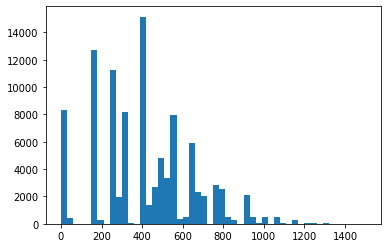

In [20]:
#example (~~~can be modified and removed)
x = soil_site_data_mass_all.set_index(['aggregated taxon','aggregated biome'])['mass_G'].sort_index()
sigma = soil_site_data_mass_all_std.set_index(['aggregated taxon','aggregated biome'])['mass_G'].sort_index()

NBins = 20
Boot_N = 100000

taxon = 'Isoptera'
biome = 'Temperate Forests'

means = Boot_means(x.loc[taxon,biome], sigma.loc[taxon,biome],Boot_N = Boot_N)
plt.hist(means,50)


In [21]:
##with alternative mean (~~~ remove all alternative means in the future?)
soil_biome_means_2 = soil_site_data_mass_all.reset_index().groupby(['aggregated taxon','aggregated biome'])['mass_G'].agg([calc_mean,calc_mean_ar,calc_mean_log,calc_mean_alt,calc_min,calc_max,calc_min_alt,calc_max_alt,calc_mean_ar_sem,'count'])
soil_biome_means_2.rename(columns={'calc_mean': 'Mean', 'calc_min': 'Min', 'calc_max': 'Max', 'calc_mean_log': 'Mean_Log', 'calc_mean_ar': 'Mean_Ar','calc_mean_ar_sem': 'Sem_Ar', 'count': 'N','count': 'N', 'calc_mean_alt':'Mean_alt','calc_min_alt': 'Min_alt', 'calc_max_alt': 'Max_alt'}, inplace=True)

#compare the means
soil_biome_means_2.div(soil_biome_means_2.Mean_Ar, axis=0) # soil_biome_means_2.loc[:,'Mean']



Mean  \
aggregated taxon aggregated biome                                               
Acari            Boreal Forests/Taiga                                0.834072   
                 Crops                                               0.840930   
                 Deserts and Xeric Shrublands                        0.735189   
                 Mediterranean Forests, Woodlands and Scrub          0.543480   
                 Pasture                                             0.530083   
                 Temperate Forests                                   0.698664   
                 Temperate Grasslands, Savannas and Shrublands       0.700198   
                 Tropical and Subtropical Forests                    0.842985   
                 Tropical and Subtropical Grasslands, Savannas a...  0.884068   
                 Tundra                                              0.765179   
Collembola       Boreal Forests/Taiga                                0.649383   
                 Crops                                               0.935053   
                 Deserts and Xeric Shrublands                        0.708769   
                 Mediterranean Forests, Woodlands and Scrub          0.833987   
                 Pasture                                             0.515225   
                 Temperate Forests                                   0.693731   
                 Temperate Grasslands, Savannas and Shrublands       0.725889   
                 Tropical and Subtropical Forests                    0.879959   
                 Tropical and Subtropical Grasslands, Savannas a...  0.998442   
                 Tundra                                              0.658320   
Formicidae       Boreal Forests/Taiga                                0.861014   
                 Crops                                               0.701990   
                 Deserts and Xeric Shrublands                        0.710657   
                 Mediterranean Forests, Woodlands and Scrub          1.000000   
                 Pasture                                             0.888462   
                 Temperate Forests                                   0.542275   
                 Temperate Grasslands, Savannas and Shrublands       0.671178   
                 Tropical and Subtropical Forests                    0.639099   
                 Tropical and Subtropical Grasslands, Savannas a...  0.940643   
                 Tundra                                                   NaN   
Isoptera         Boreal Forests/Taiga                                     NaN   
                 Crops                                               0.669704   
                 Deserts and Xeric Shrublands                        0.546595   
                 Mediterranean Forests, Woodlands and Scrub          0.707299   
                 Pasture                                             0.549715   
                 Temperate Forests                                   0.526453   
                 Temperate Grasslands, Savannas and Shrublands       0.521111   
                 Tropical and Subtropical Forests                    0.626458   
                 Tropical and Subtropical Grasslands, Savannas a...  0.707354   
                 Tundra                                                   NaN   
Other            Boreal Forests/Taiga                                0.683520   
                 Crops                                               0.790103   
                 Pasture                                             0.649645   
                 Temperate Forests                                   0.819023   
                 Temperate Grasslands, Savannas and Shrublands       0.668495   
                 Tropical and Subtropical Forests                    0.604173   
                 Tropical and Subtropical Grasslands, Savannas a...  0.673334   
                 Tundra                                              0.669841   

                      

In [22]:
#Compare the minimum values (~~~ remove later)
soil_biome_mean_std_boot.div(soil_biome_means_G.Min+1e-5, axis=0)

mean  \
aggregated taxon aggregated biome                                              
Acari            Boreal Forests/Taiga                                1.49845   
                 Crops                                               1.65954   
                 Deserts and Xeric Shrublands                          2.113   
                 Mediterranean Forests, Woodlands and Scrub          11.5506   
                 Pasture                                             16.7176   
                 Temperate Forests                                   2.51518   
                 Temperate Grasslands, Savannas and Shrublands       2.48861   
                 Tropical and Subtropical Forests                    1.45917   
                 Tropical and Subtropical Grasslands, Savannas a...   2.7827   
                 Tundra                                              1.89236   
Collembola       Boreal Forests/Taiga                                3.33351   
                 Crops                                               1.47795   
                 Deserts and Xeric Shrublands                        2.41392   
                 Mediterranean Forests, Woodlands and Scrub          1.50223   
                 Pasture                                             1086.63   
                 Temperate Forests                                   2.58527   
                 Temperate Grasslands, Savannas and Shrublands       2.20918   
                 Tropical and Subtropical Forests                    1.39405   
                 Tropical and Subtropical Grasslands, Savannas a...  1.08638   
                 Tundra                                               3.1641   
Formicidae       Boreal Forests/Taiga                                3.33723   
                 Crops                                               2.50193   
                 Deserts and Xeric Shrublands                         2.3525   
                 Mediterranean Forests, Woodlands and Scrub                1   
                 Pasture                                             1.30243   
                 Temperate Forests                                   12.5929   
                 Temperate Grasslands, Savannas and Shrublands       4.09345   
                 Tropical and Subtropical Forests                    4.38432   
                 Tropical and Subtropical Grasslands, Savannas a...  1.26969   
                 Tundra                                                    0   
Isoptera         Boreal Forests/Taiga                                      0   
                 Crops                                               2.99861   
                 Deserts and Xeric Shrublands                        43.1714   
                 Mediterranean Forests, Woodlands and Scrub          2.43659   
                 Pasture                                             10.0025   
                 Temperate Forests                                   19.0632   
                 Temperate Grasslands, Savannas and Shrublands       1287.44   
                 Tropical and Subtropical Forests                    3.98068   
                 Tropical and Subtropical Grasslands, Savannas a...  2.40332   
                 Tundra                                                    0   
Other            Boreal Forests/Taiga                                2.72574   
                 Crops                                                 1.715   
                 Pasture                                             3.35559   
                 Temperate Forests                                   1.56385   
                 Temperate Grasslands, Savannas and Shrublands       3.00703   
                 Tropical and Subtropical Forests                    4.81636   
                 Tropical and Subtropical Grasslands, Savannas a...  3.14429   
                 Tundra                                              2.97051   

                                                                       

8. Prepare plot and read data for termites

In [23]:
def legend_without_duplicate_labels(ax,pos):
    handles, labels = ax.get_legend_handles_labels()
    mapping = [ ['Acari', 'Acari (Mites & Ticks)'],['Collembola', 'Collembola (Springtails)'],['Formicidae','Formicidae (Ants)'],['Isoptera', 'Isoptera (Termites)'],['Other','Others']]
    labels2 = [x.replace(subM[0], subM[1]) for x in labels for subM in mapping if subM[0] in x]
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels2)) if l not in labels2[:i]]
    unique = [unique[0],unique[1],unique[2], unique[3], unique[4]]      ## can be removed
    ax.legend(*zip(*unique),bbox_to_anchor=pos,loc = 'lower left', ncol=5)


In [24]:
Isoptera_data = pd.read_excel('data/IsopteraData.xlsx')

In [25]:
#Get the aggregated biome areas for use in the plot below
biome_area = pd.read_csv('data/aggregated biomes data.csv') # biomes area in units of m^2
biome_area1 = biome_area.groupby('aggregated biome 1')['area'].sum() #aggregate the biomes areas
biome_area1/1e12

aggregated biome 1
Boreal Forests/Taiga                                            15.700
Crops                                                           15.300
Deserts and Xeric Shrublands                                    19.600
Mediterranean Forests, Woodlands and Scrub                       1.620
Pasture                                                         27.600
Temperate Forests                                               10.760
Temperate Grasslands, Savannas and Shrublands                    5.430
Tropical and Subtropical Forests                                17.643
Tropical and Subtropical Grasslands, Savannas and Shrublands    10.400
Tundra                                                           7.490
Name: area, dtype: float64

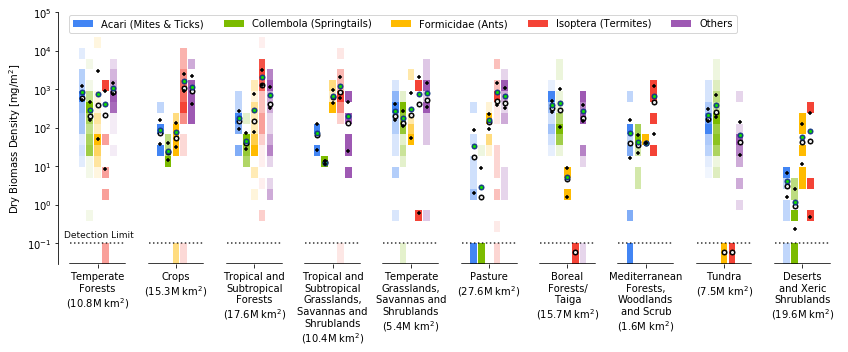

In [26]:
r = soil_site_data_mass_all.reset_index().rename(columns={'mass_G':'numerical value'}) #'numerical value' is the column being used later

#Sort according to biomes total mean biomass, in a descending order
sorter = soil_biome_means_G.reset_index().groupby('aggregated biome').sum().sort_values(by='Mean',ascending=False).index
sorterIndex = dict(zip(sorter, range(len(sorter))))
r['sorting_biomes'] = r['aggregated biome'].map(sorterIndex)
r.sort_values(['sorting_biomes'],ascending = True, inplace = True)
r.drop('sorting_biomes', 1, inplace = True)

original_biomes = r['aggregated biome'].unique()
transdict = {'Boreal Forests/Taiga': 'Boreal\nForests/\nTaiga\n(15.7M km$^2$)',
             'Crops':'Crops\n(15.3M km$^2$)',
             'Deserts and Xeric Shrublands':'Deserts\nand Xeric\nShrublands\n(19.6M km$^2$)',
             'Mediterranean Forests, Woodlands and Scrub':'Mediterranean\nForests,\nWoodlands\nand Scrub\n(1.6M km$^2$)',
             'Pasture':'Pasture\n(27.6M km$^2$)',
           'Temperate Forests':'Temperate\nForests\n(10.8M km$^2$)',
           'Temperate Grasslands, Savannas and Shrublands':'Temperate\nGrasslands,\nSavannas and\nShrublands\n(5.4M km$^2$)',
           'Tropical and Subtropical Forests':'Tropical and\nSubtropical\nForests\n(17.6M km$^2$)',
           'Tropical and Subtropical Grasslands, Savannas and Shrublands':'Tropical and\nSubtropical\nGrasslands,\nSavannas and\nShrublands\n(10.4M km$^2$)',
           'Tundra':'Tundra\n(7.5M km$^2$)'
            }

print_biomes = [transdict[biome] for biome in original_biomes]
r4 = r.replace(to_replace=original_biomes,value=print_biomes)
r4 = r4.loc[r4['numerical value']>=0] ###

bins = np.logspace(-1,np.log10(r4['numerical value'].max()),20)
bins = np.insert(bins,0,-0.1) #add the point -0.1 to the beginning of the bins array
#bins = np.logspace(r4['numerical value'].min(),r4['numerical value'].max(),20)   
t = r4.groupby(['aggregated biome','aggregated taxon'])['numerical value'].apply(lambda x: pd.cut(x,bins=bins).value_counts()/len(x)).reset_index()
y = t.groupby(['aggregated biome','aggregated taxon'])['numerical value'].apply(np.max).reset_index()
t3 = t.merge(y,left_on=['aggregated biome','aggregated taxon'],right_on=['aggregated biome','aggregated taxon'])
t3['val'] = t3['numerical value_x']/t3['numerical value_y']


Isoptra = Isoptera_data.replace(to_replace=original_biomes,value=print_biomes)


fig,ax=plt.subplots(figsize=[12,5]) #[11,4])

fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
col_arr = ['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3']

def print_data(x):
    col_map = pd.Series(col_arr,index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    if x['val'].values[0] == 1:
        lab = x['aggregated taxon'].values[0]
    else:
        lab=None
    plt.bar(x=xloc,
            height=x['level_2'].values[0].right-x['level_2'].values[0].left,
            width=0.17,
            bottom=x['level_2'].values[0].left,
            log=True,color=col,alpha=x['val'].values[0],
            label=lab,
            zorder=1
           )
    ax.set_yscale('symlog',linthreshy=0.1)
    
    
def print_mean_median(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Mean = x['numerical value'].mean()
    SEM = x['numerical value'].sem()
    Y = (Mean, Mean - SEM , Mean + SEM)
    plt.scatter(x=xloc,y=Y[0],marker='.',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y[1],marker='_',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y[2],marker='_',c='k',s=40,zorder=3)
    
    
def print_mean_log(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = LogMean(x['numerical value'],kk = 1,scale = Scale)
    plt.scatter(x=xloc,y= Y[0],marker='o',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= Y[1],marker='2',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= Y[2],marker='1',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= (Y[0]+x['numerical value'].mean())/2,marker='4',c='m', alpha=1,s=40,zorder=4)
    

def print_combined_mean(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = calc_mean(x['numerical value'])+0.08
    plt.scatter(x=xloc,y= Y,marker='.' ,c='k', alpha=1,s=100,zorder=3)
    plt.scatter(x=xloc,y= Y,marker='.' ,c='#EBEBEB', alpha=1,s=15,zorder=3)  
    
def print_mean_alt(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = Mean_alt(x['numerical value'])[0]+0.08
    L = Mean_alt(x['numerical value'])[1]
    U = Mean_alt(x['numerical value'])[2]
    plt.scatter(x=xloc,y= Y,marker='.' ,c='r', alpha=1,s=100,zorder=3)
    plt.scatter(x=xloc,y= Y,marker='.' ,c='y', alpha=1,s=15,zorder=3)  
    plt.scatter(x=xloc,y= L,marker='_' ,c='r', alpha=1,s=15,zorder=3)  
    plt.scatter(x=xloc,y= U,marker='_' ,c='r', alpha=1,s=15,zorder=3)  

def print_combined_errors(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y1 = calc_min(x['numerical value'])
    Y2 = calc_max(x['numerical value'])
    plt.scatter(x=xloc,y=Y1 ,marker='_',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y2 ,marker='_',c='k',s=40,zorder=3)
    
#Print fine average of Isoptera
def print_mean_Isoptera(x):
    fine_loc_Iso = 0.2;
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc_Iso
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='#EBEBEB', alpha=1,s=15,zorder=4)
    plt.scatter(x=xloc,y=x['Low estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['High estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)


def print_bootstrap(x):
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    x = x.replace(to_replace=original_biomes,value=print_biomes)
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = x['mean']
    L = x['2.5%']
    U = x['97.5%']
    plt.scatter(x=xloc,y= Y,marker='.' ,c='#153B80', alpha=1,s=100,zorder=3)
    plt.scatter(x=xloc,y= Y,marker='.' ,c='#10DC00', alpha=1,s=15,zorder=3)  
    plt.scatter(x=xloc,y= L,marker='+' ,c='k', alpha=1,s=15,zorder=3)  
    plt.scatter(x=xloc,y= U,marker='+' ,c='k', alpha=1,s=15,zorder=3) 
#    plt.scatter(x=xloc,y= L,marker='_' ,c='#10DC00', alpha=0.9,s=10,zorder=3)  
#    plt.scatter(x=xloc,y= U,marker='_' ,c='#10DC00', alpha=0.9,s=10,zorder=3) 
   

    
#     if x['val'].values[0] >0:
#         plt.plot([xloc-0.17/2,xloc+0.17/2],[x['level_2'].values[0].right,x['level_2'].values[0].right],color='k',linewidth=0.7,alpha=1)
for i in range(0,2*len(r4['aggregated biome'].unique()),2):    
    plt.plot([i-0.7,i+0.7],[0.05,0.05],'k')   #plot lines for labels
    plt.plot([i-0.7,i+0.7],[1e-1,1e-1],'k:',alpha = 0.8)    #plot dotted lines for breaking points "detection limit"

#Plot data
ax = t3.groupby(['aggregated biome','aggregated taxon','level_2']).apply(print_data)
ax = plt.gca()
ax.set_xticks(range(0,2*len(r4['aggregated biome'].unique()),2))
ax.set_xticklabels(r4['aggregated biome'].unique())
ax.get_label()
ax.set_ylabel('Dry Biomass Density [mg/m$^2$]')
#plt.legend()
ax.set_ylim([0.05,1e5])
ax.set_xlim([-1,19])
legend_without_duplicate_labels(ax,(0.007,0.9)) #(0.98,0))
sb.despine(top=True, bottom=True, right=True)
#r4.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_median)##
#r4.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_log)##
#Isoptra.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_Isoptera)##
#r4.groupby(['aggregated biome','aggregated taxon']).apply(print_combined_errors)##
r4.groupby(['aggregated biome','aggregated taxon']).apply(print_combined_mean)###
#r4.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_alt)###
soil_biome_mean_std_boot.reset_index().groupby(['aggregated biome','aggregated taxon']).apply(print_bootstrap)###

ax.text(0.007, 0.135, 'Detection Limit', transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=None, color = 'k', alpha = 0.95)

plt.tight_layout()


#Save:
#plt.savefig('results/fig_mass_dens_all_G.svg',dpi=300) ##
#plt.savefig('results/fig_mass_dens_all_G.pdf',dpi=300) ##
#plt.savefig('results/fig_mass_dens_all_G.png',dpi=600) ##


9. Calculate the total population in soils

In [27]:
soil_biome_Mean = soil_biome_means_G  #Change _G or _B for global or biome-level ind. mass, where applicable

##--Change termites means to carful estimates--
#Isoptera_data = pd.read_excel('data/IsopteraData.xlsx')
#Isoptera_data.set_index('aggregated biome' , inplace = True)
#soil_biome_Mean.Mean.Isoptera = Isoptera_data.loc[:,'Mid estimate']
#soil_biome_Mean.Min.Isoptera = np.minimum(Isoptera_data.loc[:,'Low estimate'], soil_biome_Mean.Min.Isoptera)# Isoptera_data.loc[:,'Low estimate']
#soil_biome_Mean.Max.Isoptera = np.maximum(Isoptera_data.loc[:,'High estimate'], soil_biome_Mean.Max.Isoptera)#Isoptera_data.loc[:,'High estimate']


biome_area = pd.read_csv('data/aggregated biomes data.csv') # import biomes area in units of m^2
biome_area1 = biome_area.groupby('aggregated biome 1')['area'].sum() #aggregate the biomes areas
soil_biome_Mean1 = soil_biome_Mean.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True) #add the total areas of the aggregated biomes to the means DF
soil_biome_Mean1.loc[:,'Total'] = (soil_biome_Mean1.loc[:,'Mean']*soil_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
soil_biome_Mean1.loc[:,'Total_high'] = (soil_biome_Mean1.loc[:,'Max']*soil_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
soil_biome_Mean1.loc[:,'Total_low'] = (soil_biome_Mean1.loc[:,'Min']*soil_biome_Mean1.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)

total_soil = soil_biome_Mean1.loc[:,['Total_high','Total','Total_low']].sum()/1e15

print('Using combined mean:')
print('total high estimate is: ' + "{:.0f}".format(total_soil['Total_high']) + ' Mt dry biomass in soils')
print('total mid estimate is: ' + "{:.0f}".format(total_soil['Total'] ) + ' Mt dry biomass in soils')
print('total low estimate is: ' + "{:.0f}".format(total_soil['Total_low'])  + ' Mt dry biomass in soils')


Using combined mean:
total high estimate is: 329 Mt dry biomass in soils
total mid estimate is: 166 Mt dry biomass in soils
total low estimate is: 85 Mt dry biomass in soils


In [28]:
soil_biome_Mean = soil_biome_mean_std_boot  #repeat for bootstrapped data

biome_area = pd.read_csv('data/aggregated biomes data.csv') # biomes area in units of m^2
biome_area1 = biome_area.groupby('aggregated biome 1')['area'].sum() #aggregate the biomes areas
soil_biome_Mean2 = soil_biome_Mean.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True) #add the total areas of the aggregated biomes to the means DF
soil_biome_Mean2.loc[:,'Total'] = (soil_biome_Mean2.loc[:,'mean']*soil_biome_Mean2.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
soil_biome_Mean2.loc[:,'Total_high'] = (soil_biome_Mean2.loc[:,'97.5%']*soil_biome_Mean2.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)
soil_biome_Mean2.loc[:,'Total_low'] = (soil_biome_Mean2.loc[:,'2.5%']*soil_biome_Mean2.loc[:,'area']).values #total population per biome, in units of mg. (use 1e18 to convert to Gt)

total_soil = soil_biome_Mean2.loc[:,['Total_high','Total','Total_low']].sum()/1e15

#Taking the sum of resampled extremes (corresponding to 95% CI for the various biomes), the biomass in soil is i nthe following range:
print('Using bootstrapping:')
print('total high estimate is: ' + "{:.0f}".format(total_soil['Total_high']) + ' Mt dry biomass in soils')
print('total mid estimate is: ' + "{:.0f}".format(total_soil['Total'] ) + ' Mt dry biomass in soils')
print('total low estimate is: ' + "{:.0f}".format(total_soil['Total_low'])  + ' Mt dry biomass in soils')


Using bootstrapping:
total high estimate is: 440 Mt dry biomass in soils
total mid estimate is: 248 Mt dry biomass in soils
total low estimate is: 117 Mt dry biomass in soils


(array([ 4.,  6.,  7., 11., 15., 25., 37., 26., 48., 62., 55., 80., 80.,
        62., 60., 66., 59., 56., 43., 42., 36., 27., 24., 15., 14., 11.,
        10.,  6.,  6.,  3.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.]), array([198.02726703, 201.52676499, 205.02626294, 208.5257609 ,
        212.02525886, 215.52475682, 219.02425478, 222.52375273,
        226.02325069, 229.52274865, 233.02224661, 236.52174457,
        240.02124253, 243.52074048, 247.02023844, 250.5197364 ,
        254.01923436, 257.51873232, 261.01823027, 264.51772823,
        268.01722619, 271.51672415, 275.01622211, 278.51572006,
        282.01521802, 285.51471598, 289.01421394, 292.5137119 ,
        296.01320985, 299.51270781, 303.01220577, 306.51170373,
        310.01120169, 313.51069964, 317.0101976 , 320.50969556,
        324.00919352, 327.50869148, 331.00818943, 334.50768739,
        338.00718535]), <a list of 40 Patch objects>)

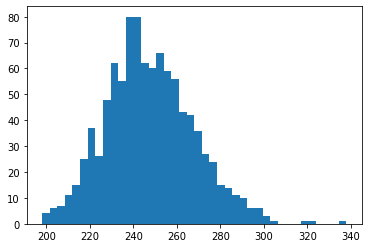

In [29]:
#plot distribution of the total biomass using bootstrapping

biome_area = pd.read_csv('data/aggregated biomes data.csv') # biomes area in units of m^2
biome_area1 = biome_area.groupby('aggregated biome 1')['area'].sum() #aggregate the biomes areas

soil_means_dist_tot = soil_means_dist.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True) #add the total areas of the aggregated biomes 
soil_means_dist_tot.loc[:,'values'] = (soil_means_dist_tot['values']*soil_means_dist_tot['area'])
soil_means_dist_tot.drop('area',axis='columns',inplace=True)

N_total_dist = 1000
total_soil_dist = np.zeros(N_total_dist) #initialize the distribution of the total soil biomass

for ii in range(N_total_dist):
    for taxon, biome in soil_means_dist.index.unique():
        cdf, values = soil_means_dist_tot.loc[taxon,biome]
        total_soil_dist[ii] += random_from_cdf(cdf,values,1)

total_soil_dist /= 1e15

plt.hist(total_soil_dist,40)

In [30]:
#extract stats from the total biomass distribution 
print(np.mean(total_soil_dist))
print(np.median(total_soil_dist))
print(np.percentile(total_soil_dist,[2.5,97.5]))
print(gmean(total_soil_dist))

247.627252681769
246.08654345879563
[211.40755246 289.86039791]
246.8209840323429


In [33]:
soil_biome_Mean2.groupby('aggregated taxon')['Total_high','Total','Total_low'].sum()/1e15

,Total_high,Total,Total_low
aggregated taxon,,,
Acari,37.196776,24.512786,14.215181
Collembola,29.868865,15.477671,6.202097
Formicidae,70.480154,28.734231,10.017566
Isoptera,182.570885,108.579675,52.964191
Other,119.808377,70.678485,33.451324


In [34]:
#summing as an error, the biomass margins are less than 50Mt (here: bootstrap)
print(sum_error(soil_biome_Mean2.loc[:,['Total_high']].values- soil_biome_Mean2.loc[:,['Total']].values)/1e15)
print(sum_error(soil_biome_Mean2.loc[:,['Total_low']].values- soil_biome_Mean2.loc[:,['Total']].values)/1e15)

47.59656812771929
31.535640097221066


In [35]:
#summing as an error, the biomass margins are less than 50Mt (here: combined mean)
print(sum_error(soil_biome_Mean1.loc[:,['Total_high']].values- soil_biome_Mean1.loc[:,['Total']].values)/1e15)
print(sum_error(soil_biome_Mean1.loc[:,['Total_low']].values- soil_biome_Mean1.loc[:,['Total']].values)/1e15)

41.15984858851944
22.542351737863275


(array([ 5., 13., 14.,  3.,  6.,  4.,  1.,  1.,  0.,  1.]),
 array([0.0, 0.28681143486149024, 0.5736228697229805, 0.8604343045844707,
        1.147245739445961, 1.4340571743074513, 1.7208686091689414,
        2.007680044030432, 2.294491478891922, 2.581302913753412,
        2.8681143486149026], dtype=object),
 <a list of 10 Patch objects>)

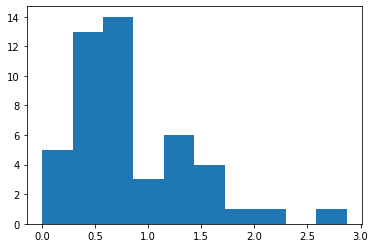

In [36]:
plt.hist((soil_biome_Mean2.loc[:,['Total_high']].values- soil_biome_Mean2.loc[:,['Total']].values)/(soil_biome_Mean2.loc[:,['Total']].values+1))

In [37]:
#difference between the two methods (30-50% higher in the bootstrap)
total_soil1 = soil_biome_Mean1.loc[:,['Total_high','Total','Total_low']].sum()/1e15
total_soil2 = soil_biome_Mean2.loc[:,['Total_high','Total','Total_low']].sum()/1e15

total_soil2/total_soil1

Total_high    1.338175
Total         1.491035
Total_low     1.375677
dtype: float64

In [38]:
soil_taxon_tot = soil_biome_Mean1.groupby('aggregated taxon')['Total_high','Total','Total_low'].sum()
print(soil_taxon_tot['Total_high']/soil_taxon_tot['Total'])
print(soil_taxon_tot['Total_low']/soil_taxon_tot['Total'])
print(soil_taxon_tot['Total']/1e15)
print(soil_taxon_tot['Total'].sum()/1e15)


aggregated taxon
Acari         1.660778
Collembola    2.066238
Formicidae    2.000198
Isoptera      2.136344
Other         1.851887
dtype: float64
aggregated taxon
Acari         0.663129
Collembola    0.533057
Formicidae    0.600928
Isoptera      0.381995
Other         0.585341
dtype: float64
aggregated taxon
Acari         18.648701
Collembola    10.642478
Formicidae    20.115044
Isoptera      66.974339
Other         49.935316
Name: Total, dtype: float64
166.3158771691281


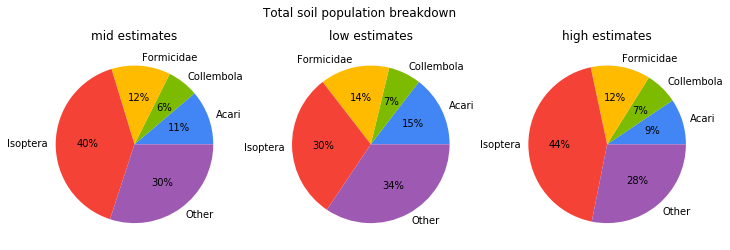

<Figure size 432x288 with 0 Axes>

In [39]:
Labels=['Acari','Collembola','Formicidae','Isoptera','Other']

fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=[12,4])
fig.suptitle('Total soil population breakdown')

ax1.pie(((soil_biome_Mean1.groupby('aggregated taxon').Total.sum())/total_soil['Total']) , colors=col_arr, labels=Labels,autopct='%1.0f%%')
ax2.pie(((soil_biome_Mean1.groupby('aggregated taxon')['Total_low'].sum())/total_soil['Total_low']) , colors=col_arr, labels=Labels,autopct='%1.0f%%')
ax3.pie(((soil_biome_Mean1.groupby('aggregated taxon')['Total_high'].sum())/total_soil['Total_high']) , colors=col_arr, labels=Labels,autopct='%1.0f%%')

ax1.title.set_text('mid estimates')
ax2.title.set_text('low estimates')
ax3.title.set_text('high estimates')

plt.show()

plt.tight_layout()

#Save:
#fig.savefig('results/fig2a_all.svg', dpi=300)
#fig.savefig('results/fig2a_all.pdf', dpi=300)

In [40]:
#calculate data normalized according to area
mg_m2 = (soil_biome_Mean1.groupby('aggregated taxon').Total.sum()/biome_area1.sum())
mg_ind = soil_ratio_filt_full.loc[:,'Total average (mg/ind)']
num_m2 = mg_m2 / mg_ind

#num_m2.sum()
biome_area1.sum()/1e14

1.31543

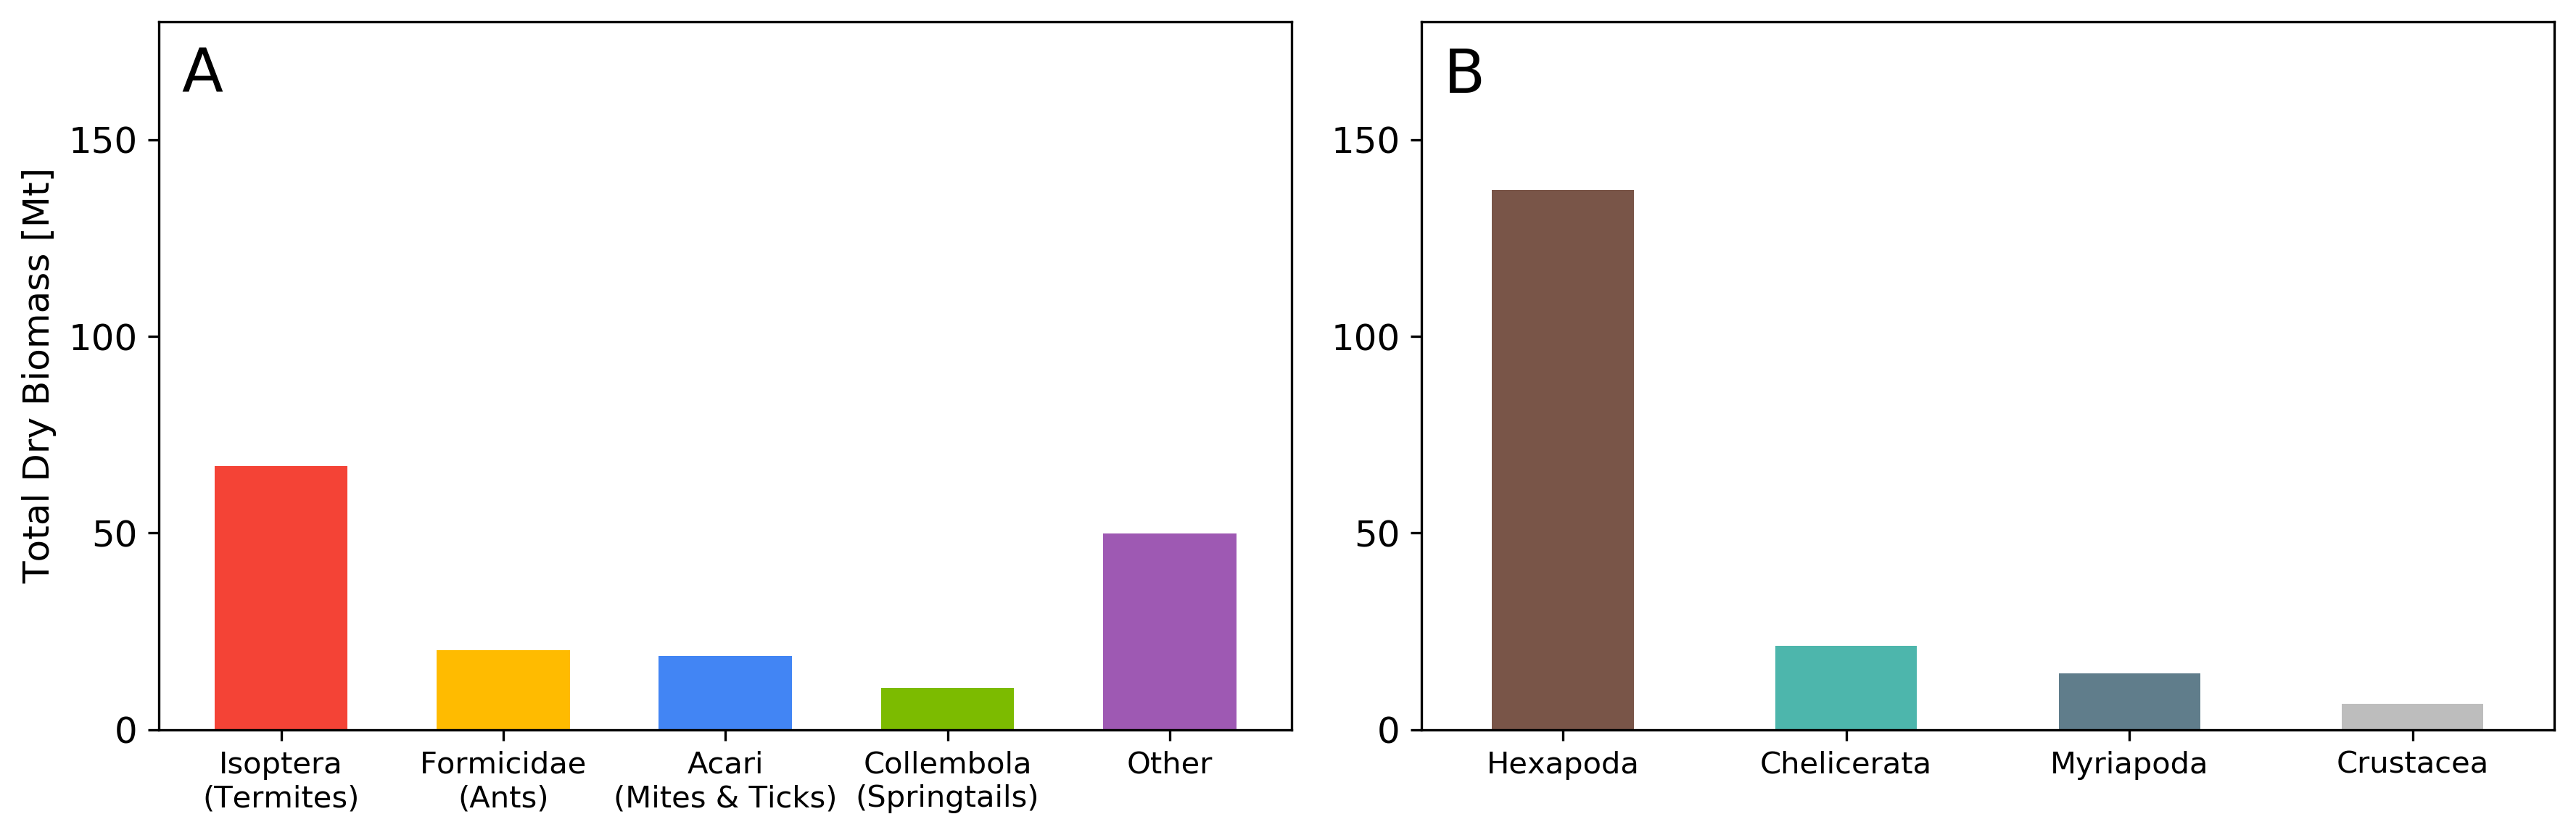

In [41]:
plt.rcParams.update({'font.size': 12}) #increase the font size here
plt.rc('text', usetex=False)


fig,ax1 = plt.subplots(1,2,figsize=[12,4],dpi=300)
ax1 = plt.subplot(1,2,1)
group_sum = (soil_biome_Mean1.groupby('aggregated taxon').Total.sum()/1e15)
group_colors = pd.Series(col_arr,index = group_sum.index)
new_index = ['Isoptera','Formicidae','Acari','Collembola','Other']
group_sum = group_sum.reindex(new_index)
group_colors = group_colors.reindex(new_index)
#group_sum.index = ['Isoptera\n(Termites)','Formicidae\n(Ants)','Acari\n(Mites & Ticks)','Collembola\n(Springtails)','Other']
group_sum.index = ['Isoptera\n(Termites)','Formicidae\n(Ants)','Acari\n(Mites & Ticks)','Collembola\n(Springtails)','Other']

group_colors.index = group_sum.index
#group_sum.sort_values(ascending=False,inplace=True)
#group_sum.sort_values(ascending=False).plot.bar(width = 0.6,color=group_colors.loc[group_sum.index],rot=0,ax=ax)
group_sum.plot.bar(width = 0.6,color=group_colors.loc[group_sum.index],rot=0,ax=ax1)
ax1.set_ylabel('Total Dry Biomass [Mt]')
plt.xticks(fontsize=10)

# (part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)
ax2 = plt.subplot(1,2,2)
subphyla_sum = pd.read_csv('results/subphyla_sum.csv') #subphyla_sum = ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/1e15)
subphyla_sum.index = subphyla_sum.iloc[:,0]
del subphyla_sum.index.name
subphyla_sum = subphyla_sum.iloc[:,1]
subphyla_colors = pd.Series(['#795548', '#4db6ac','#607d8b','#bdbdbd'],index = subphyla_sum.index)
#subphyla_sum.sort_values(ascending=False,inplace=True)
subphyla_sum.plot.bar(width = 0.5,color=subphyla_colors.loc[subphyla_sum.index],ax=ax2,rot=0)
plt.xticks(fontsize=10)

ax1.set_ylim([0,180])
ax2.set_ylim([0,180])
ax1.set(yticks=np.arange(0,200,50))
ax2.set(yticks=np.arange(0,200,50))


#ax.set_ylim([0,0.21])
#ax2.set_ylim([0,0.21])
#ax.set(yticks=np.arange(0,0.25,0.05))
#ax2.set(yticks=np.arange(0,0.25,0.05))
# ax.set_ylabel('Biomass [Gt]')
# plt.savefig('results/fig2b.svg', dpi=300)
#ax.text(-1,160,'A',fontdict={'size':20})
#ax2.text(-1,160,'B',fontdict={'size':20})
ax1.text(0.02,0.9,'A',fontdict={'size':20},transform = ax1.transAxes)
ax2.text(0.02,0.9,'B',fontdict={'size':20},transform = ax2.transAxes)
plt.tight_layout()

#plt.savefig('results/fig2.svg', dpi=300)
#plt.savefig('results/fig2.pdf', dpi=300)##
#plt.savefig('results/fig2.png', dpi=300)##

# plt.savefig('results/fig2b.svg', dpi=300)
# ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp.nominal_value)

plt.rcParams.update({'font.size': 10}) #decrease back the font size here

In [42]:
subphyla_sum = pd.read_csv('results/subphyla_sum.csv') #subphyla_sum = ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/1e15)
subphyla_sum.index = subphyla_sum.iloc[:,0]
subphyla_sum = subphyla_sum.iloc[:,1]
subphyla_sum

Unnamed: 0
Hexapoda       137.210509
Chelicerata     21.389202
Myriapoda       14.300360
Crustacea        6.602141
Name: 0, dtype: float64

Data in canopies and on surface is too scarse to use an effective mass, and we see from the population and the mass measurements that it'll not change the overall estimation much, hence  (??), and the sub-phyla division is too coarse to use it (the spread of individual masses is too large in this case). 

12. Calculate the overall total population, assuming places with no data has no individuals

overall_population = total_surface+total_canopy+total_soil
overall_population

13. Calculate and plot the total population per aggregated biome 

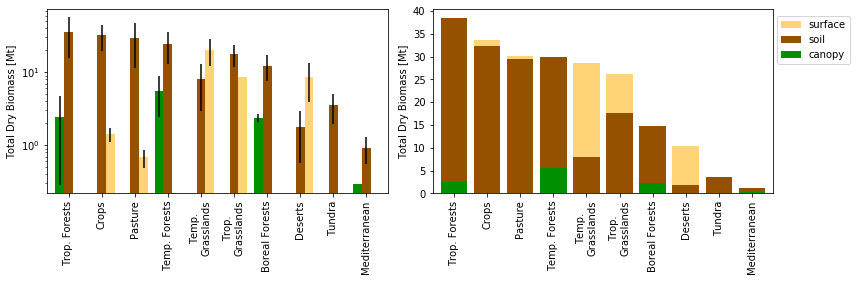

In [43]:
#The total soil biomass calculated here (Gt), using both population and biomass data
Soil_mass = soil_biome_Mean1.loc[:,['Total_high','Total','Total_low']].groupby('aggregated biome').sum()/1e15
Soil_mass=Soil_mass.reset_index()
Soil_mass.insert(0, 'env', 'soil',True)

#Read the total biomass of canopy and surface and replace the soil biomass to the current estimation 
biome_totals_mass = pd.read_csv('results/table_biome_totals_mass.csv')
biome_totals_mass.loc[biome_totals_mass['env']=='soil'] = Soil_mass

biome_totals_pop = pd.read_csv('results/table_biome_totals_pop.csv')

def sort_by_index(x,sorted_indx):
    sorterIndex = dict(zip(sorted_indx, range(len(sorted_indx))))
    x['sorting_biomes'] = x.index.map(sorterIndex)
    x.sort_values(['sorting_biomes'],ascending = True, inplace = True)
    x.drop('sorting_biomes', 1, inplace = True)
    return x

def data4tot_plot(x):
    #rename labels for plot
    original_biomes = x['aggregated biome']
    transdict = {'Boreal Forests/Taiga': 'Boreal Forests',
             'Crops':'Crops',
             'Deserts and Xeric Shrublands':'Deserts',
             'Mediterranean Forests, Woodlands and Scrub':'Mediterranean',
             'Pasture':'Pasture',
           'Temperate Forests':'Temp. Forests',
           'Temperate Grasslands, Savannas and Shrublands':'Temp.\nGrasslands',
           'Tropical and Subtropical Forests':'Trop. Forests',
           'Tropical and Subtropical Grasslands, Savannas and Shrublands':'Trop.\nGrasslands',
           'Tundra':'Tundra'
            }
    print_biomes = [transdict[biome] for biome in original_biomes]    
    x['aggregated biome'] = print_biomes
    
    #total values
    x_tot = x.reset_index().pivot(index = 'aggregated biome' , columns = 'env', values='Total')    
    
    #sort by descending values
    sorter = x_tot.sum(axis=1).sort_values(ascending=False).index
    x_tot = sort_by_index(x_tot ,sorter )
    
    x['err_low'] = (x.loc[:,'Total']-x.loc[:,'Total_low'])
    x['err_high'] = (x.loc[:,'Total_high']-x.loc[:,'Total'])
    
    err_l = x.pivot(index = 'aggregated biome' , columns = 'env', values='err_low' ) 
    err_l = sort_by_index(err_l,x_tot.index)
    err_h = x.pivot(index = 'aggregated biome' , columns = 'env', values= 'err_high')
    err_h = sort_by_index(err_l,x_tot.index)
    
    err = []
    for col in err_l:  # Iterate over bar groups (represented as columns)
        err.append([err_l[col].values, err_h[col].values])    
        
    return x_tot , err


mass_tots, err_m = data4tot_plot(biome_totals_mass)
pop_tots, err_p= data4tot_plot(biome_totals_pop)


fig = plt.subplots(figsize=[12,4])
ax = plt.subplot(1,2,1)
mass_tots.plot.bar(yerr=err_m ,width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax,logy=True,stacked=False,rot=90,legend=False)
ax.set_ylabel('Total Dry Biomass [Mt]')
#ticklabels = ['Boreal Forest', 'Crops','Desert','Mediteranian', 'Pasture','Temp. Forest', 'Temp.\nGrassland', 'Trop. Forest','Trop.\nGrassland','Tundra']
#ax.xaxis.set_ticklabels(ticklabels)
ax.xaxis.label.set_visible(False)
#ax.set_ylim([0,100])
#ax.legend(loc = [1.01,0.7])
#ax.ticks

ax = plt.subplot(1,2,2)
mass_tots.plot.bar(width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax,logy=False,stacked=True)
ax.set_ylabel('Total Dry Biomass [Mt]')
#ax.xaxis.set_ticklabels(ticklabels)
ax.xaxis.label.set_visible(False)
#ax.set_ylim([0,100])
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[2],handles[1],handles[0]],[labels[2],labels[1],labels[0]],loc = [1.01,0.7])

plt.tight_layout()

#plt.savefig('results/fig_pop_biome_totsig_.svg', dpi=300)
#plt.savefig('results/fig_pop_biome_tots.pdf', dpi=300)##

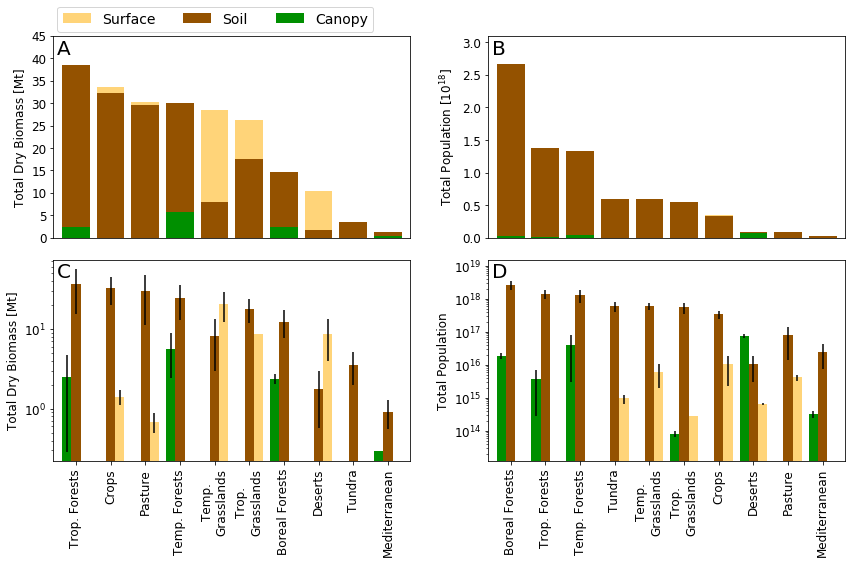

In [44]:
plt.rcParams.update({'font.size': 12}) #increase the font size here

fig = plt.subplots(figsize=[12,8])


ax1 = plt.subplot(2,2,1)
mass_tots.plot.bar(width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax1,logy=False,stacked=True)
ax1.set_ylabel('Total Dry Biomass [Mt]')
#ax.xaxis.set_ticklabels(ticklabels)
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
ax1.set_ylim([0,45])
handles, labels = ax1.get_legend_handles_labels()

transdict = {'surface': 'Surface',
             'soil': 'Soil',
             'canopy': 'Canopy'
            }
Labels = [transdict[env] for env in labels]

ax1.legend([handles[2],handles[1],handles[0]],[Labels[2],Labels[1],Labels[0]],loc = [0.01,1.02],ncol=3,fontsize=14)
#ax1.legend([handles[2],handles[1],handles[0]],['Surface','Soil','Canopy'],loc = [0.01,1.02],ncol=3,fontsize=12)
ax1.text(0.01,0.91,'A',fontdict={'size':20},transform = ax1.transAxes)

ax2 = plt.subplot(2,2,2)
(pop_tots/1e18).plot.bar(width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax2,logy=False,stacked=True)
ax2.set_ylabel('Total Population [$10^{18}$]')
#ax.xaxis.set_ticklabels(ticklabels)
x_axis = ax2.axes.get_xaxis()
x_axis.set_visible(False)
ax2.set_ylim([0,3.1])
ax2.get_legend().remove()
ax2.text(0.01,0.91,'B',fontdict={'size':20},transform = ax2.transAxes)


ax3 = plt.subplot(2,2,3)
mass_tots.plot.bar(yerr=err_m ,width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax3,logy=True,stacked=False,rot=90,legend=False)
ax3.set_ylabel('Total Dry Biomass [Mt]')
#ticklabels = ['Boreal Forest', 'Crops','Desert','Mediteranian', 'Pasture','Temp. Forest', 'Temp.\nGrassland', 'Trop. Forest','Trop.\nGrassland','Tundra']
#ax.xaxis.set_ticklabels(ticklabels)
ax3.xaxis.label.set_visible(False)
#ax.set_ylim([0,100])
#ax.legend(loc = [1.01,0.7])
#ax.ticks
ax3.text(0.01,0.91,'C',fontdict={'size':20},transform = ax3.transAxes)

ax4 = plt.subplot(2,2,4)
pop_tots.plot.bar(yerr=err_p ,width = 0.8, color=['#008F00','#945200', '#FFD479' ],ax=ax4,logy=True,stacked=False,rot=90,legend=False)
ax4.set_ylabel('Total Population')
#ticklabels = ['Boreal Forest', 'Crops','Desert','Mediteranian', 'Pasture','Temp. Forest', 'Temp.\nGrassland', 'Trop. Forest','Trop.\nGrassland','Tundra']
#ax.xaxis.set_ticklabels(ticklabels)
ax4.xaxis.label.set_visible(False)
ax4.set_ylim([1.2e13,1.5e19])
#ax.legend(loc = [1.01,0.7])
#ax.ticks
ax4.text(0.01,0.91,'D',fontdict={'size':20},transform = ax4.transAxes)

plt.tight_layout()

plt.rcParams.update({'font.size': 10}) #increase the font size here

#plt.savefig('results/fig_tots.svg', dpi=300)
#plt.savefig('results/fig_tots.pdf', dpi=300)##
#plt.savefig('results/fig_tots.png', dpi=300)##

In [45]:
soil_biome_means_G.reset_index(inplace=True)
Isoptera_G = soil_biome_means_G[soil_biome_means_G['aggregated taxon']=='Isoptera']
Isoptera_G.to_csv('results/Isoptera_G.csv')##